In [17]:
#!pip install kaggle_environments

ERROR: Operation cancelled by user


In [18]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from kaggle_environments import evaluate, make

In [19]:
# کلاس ConnectX که از کلاس gym.Env ارث بری می‌کند
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=False)
        self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob

        # تعریف فضاهای لازم برای gym:
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        return self.trainer.step(action)

    def reset(self):
        if np.random.random() < self.switch_prob:
            self.switch_trainer()
        return self.trainer.reset()

    def render(self, **kwargs):
        return self.env.render(**kwargs)


# کلاس DeepModel که از کلاس tf.keras.Model ارث بری می‌کند
class DeepModel(tf.keras.Model):
    def __init__(self, num_states, hidden_units, num_actions):
        super(DeepModel, self).__init__()
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(num_states,))
        self.hidden_layers = []
        for i in hidden_units:
            self.hidden_layers.append(tf.keras.layers.Dense(
                i, activation='sigmoid', kernel_initializer='RandomNormal'))
        self.output_layer = tf.keras.layers.Dense(
            num_actions, activation='linear', kernel_initializer='RandomNormal')

    def call(self, inputs):
        z = self.input_layer(inputs)
        for layer in self.hidden_layers:
            z = layer(z)
        output = self.output_layer(z)
        return output


# کلاس DQN برای الگوریتم DQN
class DQN:
    def __init__(self, num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr):
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.optimizer = tf.optimizers.Adam(lr)
        self.gamma = gamma
        self.model = DeepModel(num_states, hidden_units, num_actions)


In [20]:
def play_game(env, TrainNet, TargetNet, epsilon, copy_step):
    rewards = 0  # مجموع پاداش‌ها
    iter = 0  # شمارنده مراحل بازی
    done = False  # وضعیت پایان بازی
    observations = env.reset()  # مشاهده اولیه
    while not done:
        action = TrainNet.get_action(observations, epsilon)  # انتخاب حرکت توسط مدل آموزش دیده شده
        prev_observations = observations  # مشاهده قبلی
        observations, reward, done, _ = env.step(action)  # اجرای حرکت و دریافت مشاهده، پاداش و وضعیت جدید
        if done:
            # تغییر دادن پاداش در صورت پایان بازی
            if reward == 1:
                reward = 20
            elif reward == 0:
                reward = -20
            else:
                reward = 10
        else:
            reward = -0.05  # تنبیه در صورت عدم پایان بازی
        rewards += reward  # اضافه کردن پاداش به مجموع پاداش‌ها
        exp = {'s': prev_observations, 'a': action, 'r': reward, 's2': observations, 'done': done}  # تجربه به صورت دیکشنری
        TrainNet.add_experience(exp)  # افزودن تجربه به بوفر (buffer)
        TrainNet.train(TargetNet)  # آموزش مدل آموزش دیده شده
        iter += 1  # افزایش شمارنده مراحل بازی
        if iter % copy_step == 0:
            TargetNet.copy_weights(TrainNet)  # کپی کردن وزن‌های مدل آموزش دیده شده به مدل هدف
    return rewards  # بازگشت مجموع پاداش‌ها


In [21]:
env = ConnectX()

In [23]:
episodes = 5000  # تعداد قسمت‌های آموزش
batch_size = 16  # اندازه دسته آموزشی برای آموزش شبکه
epsilon = 1  # مقدار شروع برای ε-greedy
epsilon_decay = 0.99  # نرخ کاهش ε-greedy در هر قسمت
epsilon_min = 0.01  # حداقل مقدار برای ε-greedy
gamma = 0.99  # پارامتر تخفیف در الگوریتم Q-Learning
update_after = 1  # تعداد قسمت‌های لازم برای شروع آموزش شبکه
update_target_after = 1  # تعداد قسمت‌های لازم برای به‌روزرسانی شبکه هدف
learning_rate = 0.001  # نرخ یادگیری شبکه
learning_rate_in = 0.001  # نرخ یادگیری برای لایه ورودی شبکه
learning_rate_out = 0.1  # نرخ یادگیری برای لایه خروجی شبکه
circuit_depth = 5  # عمق مدار کوانتومی
epsilon_schedule = 'fast'  # برنامه‌ریزی نرخ کاهشی برای ε-greedy
use_reuploading = True  # استفاده از تکنیک بارگذاری مجدد در شبکه کوانتومی
trainable_scaling = True  # قابلیت آموزش وزن‌های تقسیم کننده در مدار کوانتومی
trainable_output = True  # قابلیت آموزش وزن‌های خروجی در مدار کوانتومی
output_factor = 1  # ضریب تقسیم برای خروجی مدار کوانتومی
reps = 10  # تعداد تکرار آموزش شبکه


In [24]:
num_states = env.observation_space.n + 1  # تعداد وضعیت‌های ممکن در محیط + 1 (برای مشخص کردن نشانه بازیکن)
num_actions = env.action_space.n  # تعداد عمل‌های ممکن در محیط

all_total_rewards = np.empty(episodes)  # آرایه‌ای برای ذخیره جوایز کلیه قسمت‌ها
all_avg_rewards = np.empty(episodes)  # آرایه‌ای برای ذخیره میانگین جوایز قسمت‌های اخیر
all_epsilons = np.empty(episodes)  # آرایه‌ای برای ذخیره مقادیر ε-greedy در هر قسمت

TrainNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)  # شبکه عصبی آموزشی
TargetNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)  # شبکه عصبی هدف


In [25]:
pbar = tqdm(range(episodes))  # ایجاد یک نوار پیشرفت برای تعداد قسمت‌ها
for n in pbar:
    epsilon = max(min_epsilon, epsilon * decay)  # محاسبه مقدار ε با توجه به شرایط تعیین شده
    total_reward = play_game(env, TrainNet, TargetNet, epsilon, copy_step)  # اجرای یک قسمت با استفاده از تابع play_game
    all_total_rewards[n] = total_reward  # ذخیره جایزه کلی قسمت فعلی در آرایه جوایز کلیه قسمت‌ها
    avg_reward = all_total_rewards[max(0, n - 100):(n + 1)].mean()  # محاسبه میانگین جوایز قسمت‌های اخیر
    all_avg_rewards[n] = avg_reward  # ذخیره میانگین جوایز قسمت فعلی در آرایه میانگین جوایز قسمت‌ها
    all_epsilons[n] = epsilon  # ذخیره مقدار ε در آرایه مقادیر ε-greedy

    pbar.set_postfix({
        'episode reward': total_reward,
        'avg (100 last) reward': avg_reward,
        'epsilon': epsilon
    })  # به‌روزرسانی نوار پیشرفت با اطلاعات مربوط به جوایز و مقدار ε در قسمت فعلی


100%|██████████| 5000/5000 [41:32<00:00,  2.01it/s, episode reward=9.9, avg (100 last) reward=14.4, epsilon=0.951]


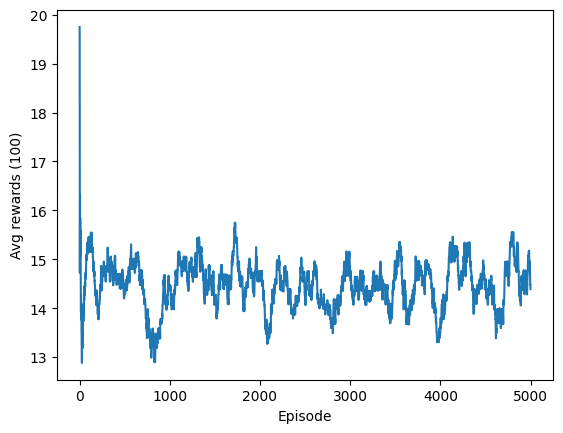

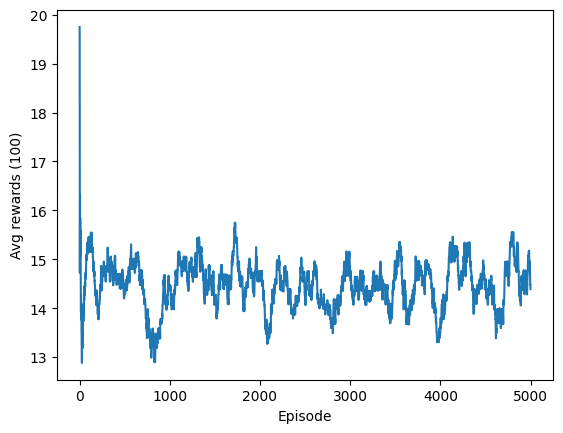

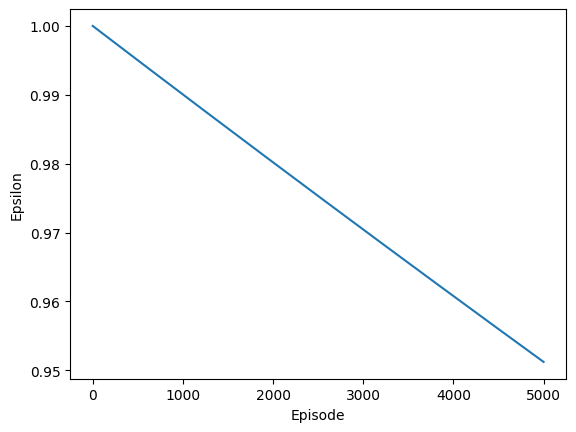

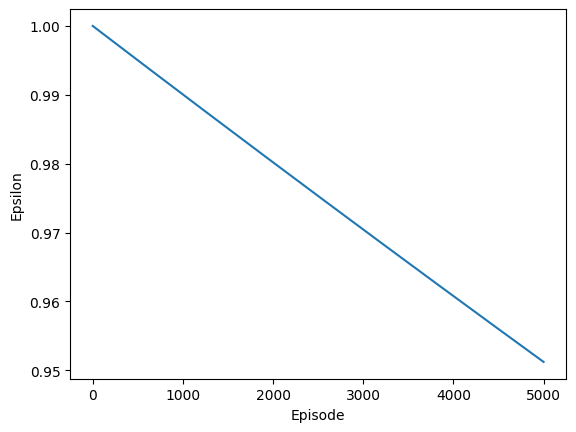

In [26]:
plt.plot(all_avg_rewards)  # رسم نمودار میانگین جوایز قسمت‌ها
plt.xlabel('Episode')  # مشخص کردن برچسب محور افقی به عنوان تعداد قسمت‌ها
plt.ylabel('Avg rewards (100)')  # مشخص کردن برچسب محور عمودی به عنوان میانگین جوایز (100 قسمت اخیر)
plt.show()  # نمایش نمودار

plt.plot(all_epsilons)  # رسم نمودار مقادیر ε در طول قسمت‌ها
plt.xlabel('Episode')  # مشخص کردن برچسب محور افقی به عنوان تعداد قسمت‌ها
plt.ylabel('Epsilon')  # مشخص کردن برچسب محور عمودی به عنوان مقدار ε
plt.show()  # نمایش نمودار


In [ ]:
TrainNet.save_weights('./weights.h5')  # ذخیره وزن‌های شبکه عصبی در فایل weights.h5


In [28]:
# تولید لایه‌های Fully Connected

fc_layers = []

# برای هر لایه‌ی مخفی
for i in range(len(hidden_units)):
    # افزودن وزن‌ها و بایاس‌ها به لیست fc_layers
    fc_layers.extend([
        TrainNet.model.hidden_layers[i].weights[0].numpy().tolist(),
        TrainNet.model.hidden_layers[i].weights[1].numpy().tolist()
    ])

# افزودن وزن‌ها و بایاس خروجی به لیست fc_layers
fc_layers.extend([
    TrainNet.model.output_layer.weights[0].numpy().tolist(),
    TrainNet.model.output_layer.weights[1].numpy().tolist()
])

# تبدیل لیست به آرایه‌ی numpy و گرد کردن اعداد
fc_layers = list(map(
    lambda x: str(list(np.round(x, precision))).replace('array(', '').replace(')', '').replace(' ', '').replace('\n', ''),
    fc_layers
))

# تغییر شکل آرایه به شکل ماتریسی
fc_layers = np.reshape(fc_layers, (-1, 2))

# تولید کد مامور my_agent

my_agent = '''def my_agent(observation, configuration):
    import numpy as np

'''

# تولید کد لایه‌های مخفی
for i, (w, b) in enumerate(fc_layers[:-1]):
    my_agent += '    hl{}_w = np.array({}, dtype=np.float32)\n'.format(i+1, w)
    my_agent += '    hl{}_b = np.array({}, dtype=np.float32)\n'.format(i+1, b)

# تولید کد لایه خروجی
my_agent += '    ol_w = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][0])
my_agent += '    ol_b = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][1])

my_agent += '''
    state = observation['board'][:]
    state.append(observation['mark'])
    out = np.array(state, dtype=np.float32)

'''

# تولید کد محاسبه خروجی شبکه
for i in range(len(fc_layers[:-1])):
    my_agent += '    out = np.matmul(out, hl{0}_w) + hl{0}_b\n'.format(i+1)
    my_agent += '    out = 1/(1 + np.exp(-out))\n'

my_agent += '    out = np.matmul(out, ol_w) + ol_b\n'

# تولید کد انتخاب بهترین حرکت
my_agent += '''
    for i in range(configuration.columns):
        if observation['board'][i] != 0:
            out[i] = -1e7

    return int(np.argmax(out))
    '''

In [29]:
# ذخیره کد مامور my_agent در فایل submission.py
with open('submission.py', 'w') as f:
    f.write(my_agent)

In [37]:
from submission import my_agent

def mean_reward(rewards):
    # محاسبه تعداد برد‌های کل و تعداد بازی‌ها
    total_wins = sum(1 for r in rewards if r[0] == 1)
    total_games = len(rewards)
    return total_wins / total_games if total_games != 0 else 0

# ارزیابی عملکرد مامور my_agent در برابر مامورهای دیگر
print("My Agent vs. Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))
print("My Agent vs. Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))
print("Random Agent vs. My Agent:", mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=10)))
print("Negamax Agent vs. My Agent:", mean_reward(evaluate("connectx", ["negamax", my_agent], num_episodes=10)))


My Agent vs. Random Agent: 1.0
My Agent vs. Negamax Agent: 0.0
Random Agent vs. My Agent: 0.2
Negamax Agent vs. My Agent: 1.0
